# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

- Открыть файл с данными и изучите его. Путь к файлу: /datasets/users_behavior.csv. Скачать датасет
- Разделить исходные данные на обучающую, валидационную и тестовую выборки.
- Исследовать качество разных моделей, меняя гиперпараметры. Кратко написать выводы исследования.
- Проверить качество модели на тестовой выборке.
- Дополнительное задание: проверить модели на вменяемость.

In [49]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [50]:
data = pd.read_csv('/datasets/users_behavior.csv')

In [51]:
data

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


###### Вывод
- Данные состоят из 3214 строк и 5 столбцов
- Целевой признак для нашей задачи – is_ultra, т.е. модель, которую мы попытаемся построить, будет предсказывать значение 1 если клиенту нужно предложить тариф "Ультра" или 0 если тариф "Смарт".
- Перед нами стоит задача классификации

- Чтобы найти, есть ли мультиколлинеарность. Построим матрицу рассеяния и посмотрим корелляцию между признаками.

           minutes  messages   mb_used  is_ultra     calls
minutes   1.000000  0.173110  0.280967  0.206955  0.982083
messages  0.173110  1.000000  0.195721  0.203830  0.177385
mb_used   0.280967  0.195721  1.000000  0.198568  0.286442
is_ultra  0.206955  0.203830  0.198568  1.000000  0.207122
calls     0.982083  0.177385  0.286442  0.207122  1.000000


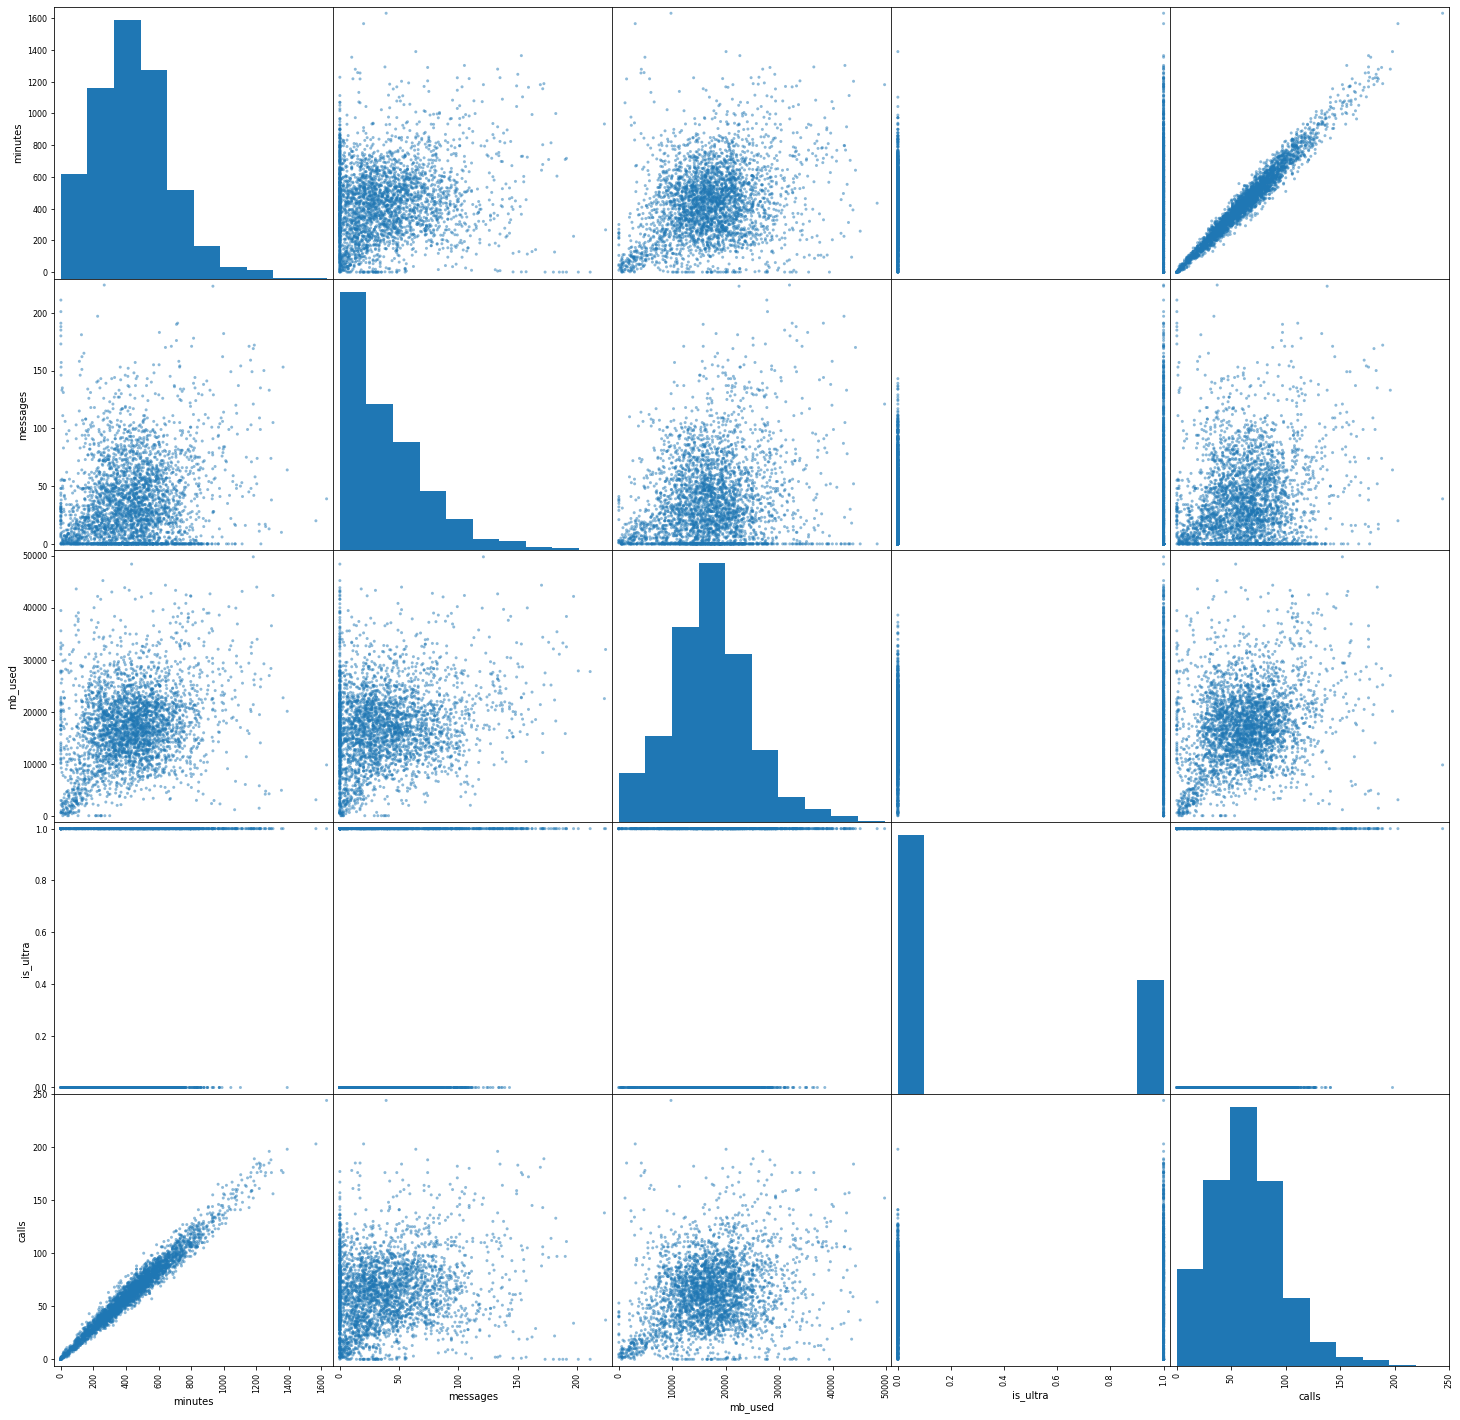

In [53]:
print(data[['minutes','messages','mb_used','is_ultra', 'calls']].corr())
pd.plotting.scatter_matrix(data[['minutes','messages','mb_used','is_ultra', 'calls']],figsize=(25,25));

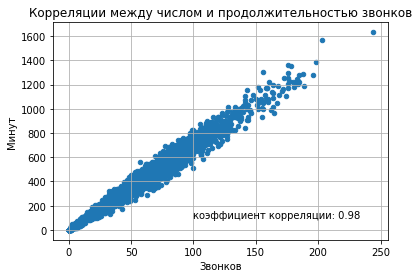

In [54]:
data.plot(x='calls', y='minutes', kind='scatter', grid=True) 
plt.text(100, 100, 'коэффициент корреляции: ' + str(round(data['calls'].corr(data['minutes']), 2)))
plt.title("Корреляции между числом и продолжительностью звонков")
plt.ylabel("Минут")
plt.xlabel("Звонков")
plt.show()

- Видим, что наблюдается высокая корелляция между звонками и минутами. Избавимся от этого признака

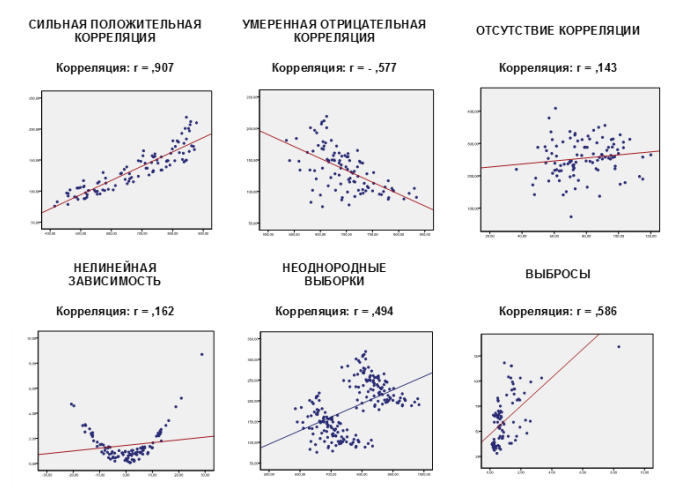

In [55]:
data.drop(['calls'], axis='columns', inplace=True)

In [56]:
data # проверяем

,minutes,messages,mb_used,is_ultra
0,311.90,83.0,19915.42,0
1,516.75,56.0,22696.96,0
2,467.66,86.0,21060.45,0
3,745.53,81.0,8437.39,1
4,418.74,1.0,14502.75,0
...,...,...,...,...
3209,910.98,20.0,35124.90,1
3210,190.36,0.0,3275.61,0
3211,634.44,70.0,13974.06,0
3212,462.32,90.0,31239.78,0


## Разбейте данные на выборки

In [57]:
# 60% отводим под обучающую выборку
data_train, data_valid = train_test_split(data, test_size=0.4, random_state=12345)

In [58]:
# половину из оставшихся 40% отдаем на валидационную, другую половину – на тестовую
data_valid, data_test = train_test_split(data_valid, test_size=0.5, random_state=12345)

###### Вывод
Все данные поделили на 60 и 40. Оставшиеся 40 поделили на две равные части. Таким образом получаем:
- Обучающеая выборка 60%
- Валидационная выборка 20%
- Тестовая выборка 20%

In [78]:
print('Размер тренирующей выборки', data_train.shape[0])
print('Размер валидационной выборки', data_valid.shape[0])
print('Размер тестовой выборки', data_test.shape[0])

Размер тренирующей выборки 1928
Размер валидационной выборки 643
Размер тестовой выборки 643


## Исследуйте модели

###### Для решения задачи классификации рассмотрим следующие изученные модели:

- дерево решений / decision tree
- случайный лес / random forest
- логистическую регрессию / logistic regression

In [59]:
#обозначим целевые признаки
features_train = data_train.drop(['is_ultra'], axis=1)
target_train = data_train['is_ultra']

features_valid = data_valid.drop(['is_ultra'], axis=1)
target_valid = data_valid['is_ultra']

features_test = data_test.drop(['is_ultra'], axis=1)
target_test = data_test['is_ultra']

In [60]:
# Функция, рассчитывающая оценку правильности на валидационной выборке для обученной модели
def accuracy_score_valid(model):
    predictions_valid = model.predict(features_valid)
    return accuracy_score(target_valid, predictions_valid)

###### Дерево решений / Decision Tree

In [61]:
# Посмотрим как глубина решающего дерева влияет на оценку правильности
for max_depth in range(1, 21, 2):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=12345)
    model.fit(features_train, target_train)
    print(f"max_depth = {max_depth}:\t{accuracy_score_valid(model)}")

max_depth = 1:	0.7542768273716952
max_depth = 3:	0.7853810264385692
max_depth = 5:	0.7884914463452566
max_depth = 7:	0.7713841368584758
max_depth = 9:	0.7791601866251944
max_depth = 11:	0.7667185069984448
max_depth = 13:	0.7573872472783826
max_depth = 15:	0.744945567651633
max_depth = 17:	0.7309486780715396
max_depth = 19:	0.7216174183514774


- Лучший результат при параметре глубины: max_depth = 5:	0.7884914463452566

###### Случайный лес

In [66]:
# В качестве гиперпараметра глубины дерева возьмем значение, найденное для предыдущей модели.
# А количество деревьев для нашего случайного леса будет искать в диапазоне от 10 до 100 с шагом 10.
for estim in range(10, 101, 10):
    model = RandomForestClassifier(n_estimators=estim, max_depth=5, random_state=12345)
    model.fit(features_train, target_train)
    print(f"n_estimators = {estim}:\t{accuracy_score_valid(model)}")
    

n_estimators = 10:	0.7853810264385692
n_estimators = 20:	0.7853810264385692
n_estimators = 30:	0.7822706065318819
n_estimators = 40:	0.7869362363919129
n_estimators = 50:	0.7853810264385692
n_estimators = 60:	0.7838258164852255
n_estimators = 70:	0.7853810264385692
n_estimators = 80:	0.7838258164852255
n_estimators = 90:	0.7807153965785381
n_estimators = 100:	0.7807153965785381


- Лучший результат при параметре количества деревьев и глубины 5(взяли с прошлого удачного показателя): n_estimators = 40:	0.7869362363919129 Результат получился хуже, дерева решении.

###### Логистическая регрессия

In [67]:
log_model = LogisticRegression(random_state=12345) # инициализируйте модель логистической регрессии с параметром random_state=12345
log_model.fit(features_train, target_train) # обучите модель на тренировочной выборке
log_predictions = log_model.predict(features_valid)
score = accuracy_score( target_valid, log_predictions)
print("Accuracy модели логистической регрессии на валидационной выборке:", score)

Accuracy модели логистической регрессии на валидационной выборке: 0.7076205287713841


###### Вывод:
- дерево решений: Лучший результат при параметре глубины: max_depth = 5:	0.7884914463452566
- случайный лес: Лучший результат при параметре количества деревьев и глубины 3(взяли с прошлого удачного показателя): n_estimators = 40: 0.7869362363919129 Результат получился хуже, дерева решении.
- логистическая регрессия показала худший рузультат Accuracy модели логистической регрессии на валидационной выборке: 0.7076205287713841

## Проверьте модель на тестовой выборке

- В результате наших экспериментов на валидационной выборке мы выяснили, что самую высокую оценку правильности дает дерево решении. Посмотрим как модель поведет себя на тестовой выборке

In [75]:
features_test = data_test.drop(['is_ultra'], axis=1)
target_test = data_test['is_ultra']

model = DecisionTreeClassifier(max_depth=max_depth, random_state=12345)
model.fit(features_train, target_train)

predictions_test = model.predict(features_test)
accuracy = accuracy_score(target_test, predictions_test)
print('Точность модели дерева решении на тестовой выборке', accuracy)

Точность модели дерева решении на тестовой выборке 0.7200622083981337


###### Вывод
- Видим что, модель показывает приближенные результаты к тренировочным. Делаем вывод, что она склонна к переобучению, значит нам удалось создать модель для классификации

## (бонус) Проверьте модели на адекватность

In [65]:
data['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

###### Вывод
accuracy модели, использующей случайное предсказание тарифа составляет 0.69 accuracy нашей модели 0.7200622083981337, что говорит о том, что она адекватней случайного угадывания.